## Are Scottish industries meeting current emissions targets?


The Scottish government has set a goal of reaching net-zero greenhouse gas (GHG) emissions against 1990 base levels by the year 2045. The government has also set itself interim targets in order to achieve this, notably a 75% reduction by 2030.

In this project we will take GHG emissions data from 1990 to 2020 for all industries, and measure this against the Scottish government's own emission reduction goals. We will aim to uncover which industries are performing well and which need more assistance to meet their targets. Furthermore, we will assess whether all industries combined meet the Scottish targets.

The dataset can be found here (entitled <i>Greenhouse Gas Dataset</i>):
https://www.gov.scot/publications/scottish-greenhouse-gas-statistics-2020/documents/

The Scottish government's goals can be found here:
https://www.gov.scot/policies/climate-change/reducing-emissions/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing the data
df = pd.read_csv('ghg_scotland_2020.csv')

In [3]:
df.head(3)

,NCFormat,IPCC_code,IPCC_name,SourceName,CRF,Old_SG_name,CCP_category,Pollutant,EmissionYear,Emmisions (MtCO2e)
0,Agriculture,1A4ci,1A4ci_Agriculture/Forestry/Fishing:Stationary,Agriculture - stationary combustion,Energy,Agriculture and related land use,Agriculture,CH4,BaseYear,0.000887
1,Agriculture,1A4ci,1A4ci_Agriculture/Forestry/Fishing:Stationary,Agriculture - stationary combustion,Energy,Agriculture and related land use,Agriculture,CH4,1990,0.000887
2,Agriculture,1A4ci,1A4ci_Agriculture/Forestry/Fishing:Stationary,Agriculture - stationary combustion,Energy,Agriculture and related land use,Agriculture,CH4,1995,0.000778


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22446 entries, 0 to 22445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NCFormat            22446 non-null  object 
 1   IPCC_code           22446 non-null  object 
 2   IPCC_name           22446 non-null  object 
 3   SourceName          22446 non-null  object 
 4   CRF                 22446 non-null  object 
 5   Old_SG_name         22446 non-null  object 
 6   CCP_category        22446 non-null  object 
 7   Pollutant           22446 non-null  object 
 8   EmissionYear        22446 non-null  object 
 9   Emmisions (MtCO2e)  22446 non-null  float64
dtypes: float64(1), object(9)
memory usage: 1.7+ MB


The columns are as follows:
- <b>Columns 0-6: </b> refer to different ways of categorising the industry being reported, including the Common Reporting Framework (CRF), Intergovernmental Panel on Climate Change (IPCC) and the old Scottish Government (Old_SG) categories. 

<i>While some categories go into more detail than others, we'll use the same category as the Scottish Government does in its reports, being the NCFormat column.</i>

- <b>Pollutant: </b> the specific gas being measured
- <b>EmissionYear: </b> the year the gas was measured
- <b>Emissions (MtCO2e)</b>: the quantity of the gas in equivalent CO2, units in megatonnes.

### Cleaning

In [5]:
#converting all column names to lowercase
df.columns = df.columns.str.lower()
df.rename(columns={'emissionyear':'emission_year', 'emmisions (mtco2e)':'mt_co2e'}, inplace=True)

In [6]:
#Understanding the dataset - let's check out how the categories are structured.
df['ncformat'].value_counts().sort_values()

Public                                      78
Residential                                364
Waste Management                           598
Exports                                   1156
Industrial processes                      1181
Land use, land use change and forestry    1716
Energy Supply                             2516
Business                                  2964
Transport                                 3166
Agriculture                               8707
Name: ncformat, dtype: int64

Some industries have more data than others. I can confirm the nature of these differences by breaking down the data in other ways, e.g. checking against a more nuanced category such as sourcename.

In [7]:
df['sourcename'].value_counts()

Autogenerators                           208
Excreta                                  208
Managed Manure                           208
Enteric                                  182
Iron and steel - combustion plant        156
                                        ... 
Crop Digestates - Direct                  10
Crop Digestates - Indirect Deposition     10
Crop Digestates - Indirect Leach          10
Gas Terminal: Direct Process               6
Oil Terminal: Direct Process               6
Name: sourcename, Length: 481, dtype: int64

Looks like that's fine. As long as each industry in question has data back to 1990, which should be also listed as the 'BaseYear', then we can use it.

In [8]:
df[df['emission_year'] == '1990'].groupby('ncformat')['emission_year'].value_counts().sort_values()

ncformat                                emission_year
Public                                  1990               3
Residential                             1990              14
Waste Management                        1990              23
Exports                                 1990              46
Industrial processes                    1990              47
Land use, land use change and forestry  1990              66
Energy Supply                           1990             100
Business                                1990             114
Transport                               1990             120
Agriculture                             1990             256
Name: emission_year, dtype: int64

In [9]:
df[df['emission_year'] == 'BaseYear'].groupby('ncformat')['emission_year'].value_counts().sort_values()

ncformat                                emission_year
Public                                  BaseYear           3
Residential                             BaseYear          14
Waste Management                        BaseYear          23
Exports                                 BaseYear          46
Industrial processes                    BaseYear          47
Land use, land use change and forestry  BaseYear          66
Energy Supply                           BaseYear         100
Business                                BaseYear         114
Transport                               BaseYear         120
Agriculture                             BaseYear         256
Name: emission_year, dtype: int64

We have a BaseYear data for each catgory, and these category names the same names as we saw above when calling the ncformat values. We also confirmed no null values earlier on, so I am satisfied there is sufficient data available since 1990.


## Analysis

### Which industries met the 2020 Scottish Government emissions targets?

Let's now take a look at the 1990-2020 industry-level data in more detail. 

We will first aim to see which industries met the Scottish government goal for 2020, being a 56% reduction in emissions on that industry's 1990 levels. To analyse this, we'll will:

- Sum the Mt_CO2e figures for each industry, by year
- Find the percentage reduction/increase for each industry on it's own 1990 baseline
- Plot this figure for each industy, by year
- Create a dataset that measures the Scottish government's goals and compare these in the same plot.

In [10]:
#Creating an industries dataframe from a groupby statement, so we can sum the emissions for each industry per year.

industries = df.groupby(['ncformat','emission_year'])['mt_co2e'].sum()
industries = pd.DataFrame(industries)
industries = industries.reset_index()
industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ncformat       260 non-null    object 
 1   emission_year  260 non-null    object 
 2   mt_co2e        260 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.2+ KB


In [11]:
#Adding a column that tracks the BaseYear emissions levels, so we can measure against it in each row

industries['base_level'] = industries.groupby('ncformat').mt_co2e.transform('first')

In [12]:
#Adding a column that calculates the emissions reduction/increase percentage for each year, compared to the base_level

industries['pct_of_baselevel'] = round((industries['mt_co2e'] - industries['base_level'])/industries['base_level']*100,2)

#Removing the 'BaseYear' data and changing year column to integer
base = ['BaseYear']
industries = industries[~industries.emission_year.isin(base)]
industries['emission_year'] = industries['emission_year'].astype(int)

In [13]:
industries.head(15)

,ncformat,emission_year,mt_co2e,base_level,pct_of_baselevel
0,Agriculture,1990,8.640922,8.640922,0.00
1,Agriculture,1995,8.746129,8.640922,1.22
2,Agriculture,1998,8.792755,8.640922,1.76
3,Agriculture,1999,8.764806,8.640922,1.43
4,Agriculture,2000,8.510877,8.640922,-1.50
5,Agriculture,2001,8.277155,8.640922,-4.21
6,Agriculture,2002,8.279424,8.640922,-4.18
7,Agriculture,2003,8.350634,8.640922,-3.36
8,Agriculture,2004,8.306732,8.640922,-3.87
9,Agriculture,2005,8.270354,8.640922,-4.29


Now we can add in the Scottish Government's targets so they will plot alongside our industry data, giving context to whether an industry is meeting the target reduction levles. 

I've compiled these targets manually to a csv, using data from the Scottish Govt website mentioned in the introduction cell.

In [14]:
#Importing the Scot Gov targets data
targets = pd.read_csv('scotgov_targets.csv')
targets_df = pd.DataFrame(targets)

#I put the reductions in positive floats, but for the purposes of the forthcoming plot, it makes more sense
#for them to be negative.
targets_df['pct_of_baselevel'] = -targets_df['pct_of_baselevel']

In [15]:
targets_df.head(10)

,ncformat,emission_year,pct_of_baselevel
0,ScotGov_Target,2018,-54.0
1,ScotGov_Target,2019,-55.0
2,ScotGov_Target,2020,-56.0
3,ScotGov_Target,2021,-57.9
4,ScotGov_Target,2022,-59.8
5,ScotGov_Target,2023,-61.7
6,ScotGov_Target,2024,-63.6
7,ScotGov_Target,2025,-65.5
8,ScotGov_Target,2026,-67.4
9,ScotGov_Target,2027,-69.3


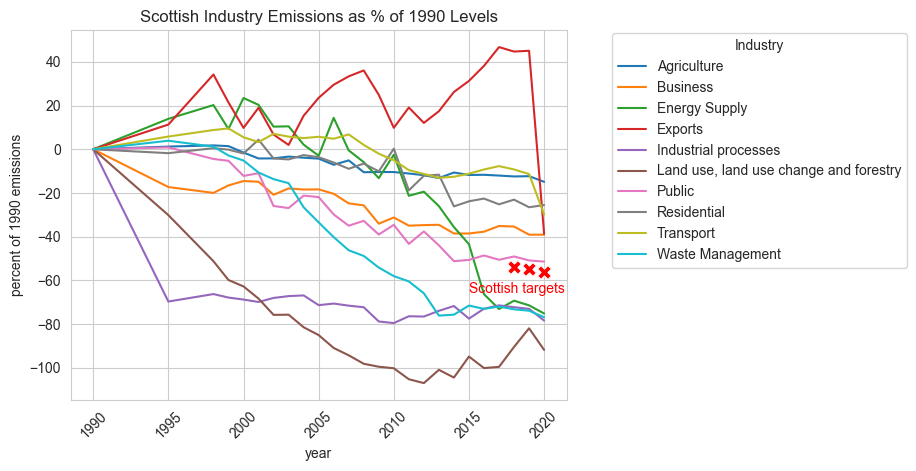

In [16]:
#Now just to plot
sns.set_style("whitegrid")

fig, ax = plt.subplots()

#Industry data
ax1 = sns.lineplot(data=industries,x='emission_year', y='pct_of_baselevel', hue='ncformat')

#Targets data. Removing anything later than 2020 for the purposes of a clean plot
ax2 = sns.scatterplot(data=targets_df[targets_df['emission_year'] < 2021], x='emission_year', y='pct_of_baselevel',
               marker='X', color='red', s=100)

plt.xticks(rotation=45)
plt.title('Scottish Industry Emissions as % of 1990 Levels')

ax.set(xlabel='year', ylabel='percent of 1990 emissions')
ax.set_xticks([1990,1995,2000,2005,2010,2015,2020])

#Two legends on a plot like this is difficult -- easier to label instead.
ax.text(.9, .3, 'Scottish targets', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='red')

sns.move_legend(ax, "center right", bbox_to_anchor=(1.7, .675), ncol=1, title='Industry', frameon=True)
plt.show()

### Discuss
From the above we can see that there is a lot of variation between Scottish industries in their emissions reduction performance.

We have some industries overreaching and beating the Scottish Government target particularly in the period 2000-2015. 
- Land Use is a great example of this, reaching below 1990 emissions from 2010-2015, but these have shown an increasing trend since that time.
- Waste Management shows a trend that had a very steady decline, operating below Scottish targets, and this is also true of Energy Supply. 
- Public industry (aka public sector) has also had a downward trend since the early 2000's, very nearly hitting Scottish targets since 2018.

With the exception of Exports, every industry has seen an overall reducing trend in emissions since 1990. However, emissions reduction since approximately 2015 look to be stagnating across all sectors. Is this a data issue, a factor of policy change, or something else?

Underperformers are industries which have made minimal reductions on the 1990 values, tracking close to 0 on the chart are Agriculture, Transport and notably, Exports.

I do not have confidence that the drop in emissions seen in Exports in 2020 will continue into future years' reporting, as this sudden drop is likely due to the COVID-19 pandemic reducing the capacity for Exports globally, as transport was significantly limited.

One thing to note here is that there is likely to be a huge amount of difference in the size and polluting capabilities of each industry. We can take a look at that next.

### Size of Industry compared to reduction levels

In [17]:
#sum all baselines. Need to drop dupes so only count one base_level once
all_industry = industries.drop_duplicates(keep='first',subset='ncformat')
total_baselevel = all_industry['base_level'].sum()
print('Total 1990 Mt CO2e: ' + str(round(total_baselevel,2)))

Total 1990 Mt CO2e: 81.56


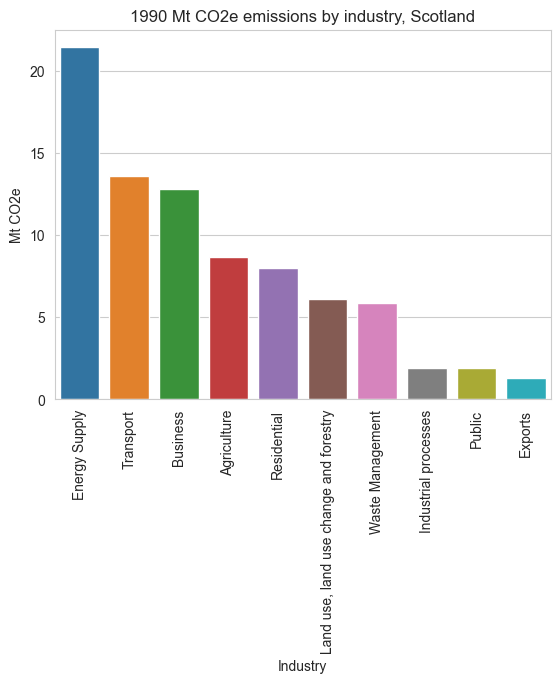

In [18]:
#Plotting industry size in 1990
all_industry=all_industry.sort_values(by='base_level', ascending=False)
sns.barplot(data=all_industry,x='ncformat',y='base_level')
plt.title('1990 Mt CO2e emissions by industry, Scotland')
plt.ylabel('Mt CO2e')
plt.xlabel('Industry')
plt.xticks(rotation=90)
plt.show()

Reveals huge differences in the emissions for each Industry e.g. Exports has not reduced it's emissions from 1990 baseline (bar 2020) but also it reports to produce much less than other industries.

The dramatic early-years changes in some industries that we saw see in the line plot probably reflect Government investing in some of the more polluting industries, e.g. Energy Supply, and areas where it was possibly to implement some lower cost (social, economic) emissions reducing initiatives, e.g. via reforestation and reducing peatland destruction in the Land Use/Forestry industry.

More intensive industries we saw lagging behind earlier are Transport and Agriculture - here represented as some of the highest polluters in 1990. These are both industries with a high social and financial cost to convert to lower-emissions solutions, and so progress may be expected to be slower.


We will check the progress of these industries against 2020 specifically below

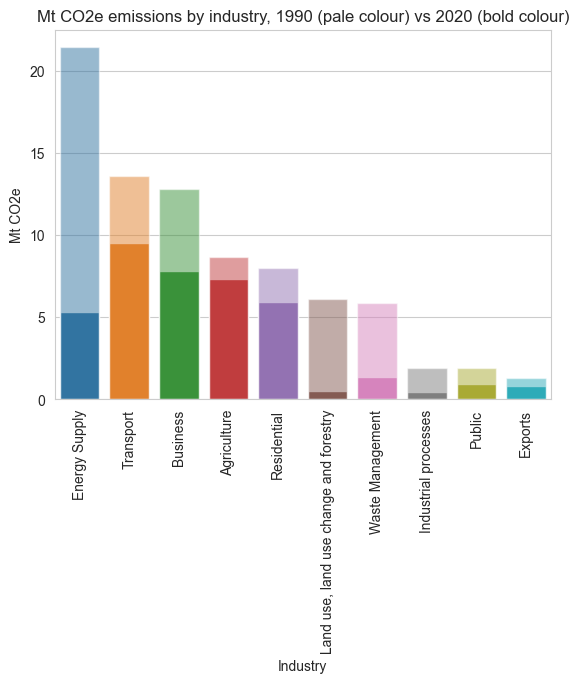

In [44]:
#Creating a new column to help with sorting the plot below according to 1990 emissions rankings
sort_dict = {'Energy Supply':0,
             'Transport':1,
             'Business':2,
             'Agriculture':3,
             'Residential':4,
             'Land use, land use change and forestry':5,
             'Waste Management':6,
             'Industrial processes':7,
             'Public':8,
             'Exports':9}

all_industry['sort_col'] = all_industry['ncformat']
all_industry['sort_col'] = all_industry['sort_col'].replace(sort_dict)

#Plotting industry size in 2020
industries_2020 = industries[industries['emission_year']==2020].sort_values(by='ncformat')
industries_2020['sort_col'] = industries_2020['ncformat']
industries_2020['sort_col'] = industries_2020['sort_col'].replace(sort_dict)


fig, ax = plt.subplots()

#2020 data plot
ax1 = sns.barplot(data=industries_2020.sort_values(by='sort_col'),x='ncformat',y='mt_co2e')
#1990 data plot
ax2 = sns.barplot(data=all_industry.sort_values(by='sort_col'),x='ncformat',y='base_level', alpha=.5)

plt.title('Mt CO2e emissions by industry, 1990 (pale colour) vs 2020 (bold colour)')
plt.ylabel('Mt CO2e')
plt.xlabel('Industry')
plt.xticks(rotation=90)
plt.show()

We can see that while Energy Supply has had a significant reduction in emissions since 1990, it remains one of the larger polluters in 2020. Nevertheless, where Energy Supply was in 1990 the most polluting industry in terms of emissions, it has been replaced by Transport, followed closely by Business and Agriculture by 2020. A great deal of work remains in the Residential industry too to reduce emissions.

Below, we confirm that Energy Supply has slipped to being the 5th most emitting industry by 2020, while the other top 4 industries are the same between 1990 and 2020.

In [42]:
all_industry

,ncformat,emission_year,mt_co2e,base_level,pct_of_baselevel,sort_col
52,Energy Supply,1990,21.459603,21.459603,0.0,0
208,Transport,1990,13.585201,13.585201,0.0,1
26,Business,1990,12.802596,12.802596,0.0,2
0,Agriculture,1990,8.640922,8.640922,0.0,3
182,Residential,1990,7.999816,7.999816,0.0,4
130,"Land use, land use change and forestry",1990,6.116443,6.116443,0.0,5
234,Waste Management,1990,5.841860,5.841860,0.0,6
104,Industrial processes,1990,1.919249,1.919249,0.0,Industrial processes
156,Public,1990,1.876648,1.876648,0.0,8
78,Exports,1990,1.315279,1.315279,0.0,9


In [20]:
top_10_1990 = industries[industries['emission_year'] == 1990].nlargest(10,['mt_co2e'])
top_10_1990

,ncformat,emission_year,mt_co2e,base_level,pct_of_baselevel
52,Energy Supply,1990,21.459603,21.459603,0.0
208,Transport,1990,13.585201,13.585201,0.0
26,Business,1990,12.802596,12.802596,0.0
0,Agriculture,1990,8.640922,8.640922,0.0
182,Residential,1990,7.999816,7.999816,0.0
130,"Land use, land use change and forestry",1990,6.116443,6.116443,0.0
234,Waste Management,1990,5.841860,5.841860,0.0
104,Industrial processes,1990,1.919249,1.919249,0.0
156,Public,1990,1.876648,1.876648,0.0
78,Exports,1990,1.315279,1.315279,0.0


In [21]:
top_10_2020 = industries[industries['emission_year'] == 2020].nlargest(10,['mt_co2e'])
top_10_2020

,ncformat,emission_year,mt_co2e,base_level,pct_of_baselevel
232,Transport,2020,9.529364,13.585201,-29.85
50,Business,2020,7.798611,12.802596,-39.09
24,Agriculture,2020,7.353001,8.640922,-14.90
206,Residential,2020,5.957383,7.999816,-25.53
76,Energy Supply,2020,5.327861,21.459603,-75.17
258,Waste Management,2020,1.351970,5.841860,-76.86
180,Public,2020,0.911754,1.876648,-51.42
102,Exports,2020,0.806457,1.315279,-38.69
154,"Land use, land use change and forestry",2020,0.500438,6.116443,-91.82
128,Industrial processes,2020,0.414654,1.919249,-78.40


### Overall Emissions Reductions

As a last piece of analysis for this section, we will look at the reductions for all industries as a whole. To do this I will:

1. Sum the mt_co2e columns for all industries, by year
2. plot the sum of all industries versus the year
3. Calculate and plot the percentage change from the baseyear level, and add in the Scottish Government emissions targets for comparison

In [22]:
#Adding base_level columnt original dataframe and cleaning the emission_year column
df['base_level'] = df.groupby(['ncformat', 'pollutant']).mt_co2e.transform('first')
base = ['BaseYear']
df = df[~df.emission_year.isin(base)]
df['emission_year'] = df['emission_year'].astype(int)


#Summing the mt_co2e column for all industries per year

all_emissions = df.groupby('emission_year')[['mt_co2e']].apply(sum)
all_emissions = all_emissions.reset_index()

In [23]:
#Adding column with base levels

all_emissions['base_level'] = float(all_emissions[all_emissions['emission_year'] == 1990].mt_co2e)
#Adding column to calculate percentage change between emission year and base level
all_emissions['pct_of_baselevel'] = round((all_emissions['mt_co2e'] - all_emissions['base_level'])/all_emissions['base_level']*100,2)


In [24]:
all_emissions

,emission_year,mt_co2e,base_level,pct_of_baselevel
0,1990,81.557617,81.557617,0.00
1,1995,80.297799,81.557617,-1.54
2,1998,80.757437,81.557617,-0.98
3,1999,77.888311,81.557617,-4.50
4,2000,79.628733,81.557617,-2.37
5,2001,78.343530,81.557617,-3.94
6,2002,74.229970,81.557617,-8.98
7,2003,74.328355,81.557617,-8.86
8,2004,71.786910,81.557617,-11.98
9,2005,70.057057,81.557617,-14.10


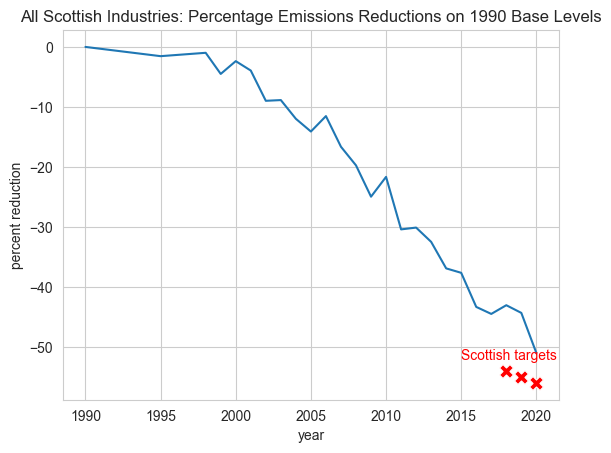

In [25]:
fig, ax = plt.subplots()

ax1 = sns.lineplot(data=all_emissions, x='emission_year', y='pct_of_baselevel')
ax2 = sns.scatterplot(data=targets_df[targets_df['emission_year'] < 2021], x='emission_year', y='pct_of_baselevel',
               marker='X', color='red', s=100)


#Two legends on a plot like this is difficult -- easier to label instead.
ax.text(.9, .12, 'Scottish targets', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='red')

plt.title('All Scottish Industries: Percentage Emissions Reductions on 1990 Base Levels')
plt.xlabel('year')
plt.ylabel('percent reduction')
plt.show()

Now from this chart we would consider Scottish industries as a whole to not be meeting the Scottish Government's emissions reduction targets for 2018-2020.

However, the Scottish Government has published a document based on this data. In this document, the authors use a new calculation from the Committee on Climate Change for accounting emissions. In particular, the new calculations build in <i>"the freezing of inventory methods (the scientific methods used for the measurement and estimation of emissions levels) between the time that target levels are set (or reviewed through independent advice from the CCC) and the time when target outcomes come to be reported."</i> 

Full report of change and explanation of how it is calculated can be found here: https://www.theccc.org.uk/publication/letter-lord-deben-roseanna-cunningham-msp-advising-scottish-climate-target-framework/

### Revised GHG accounting
According to the revised GHG accounting methods, the Scottish Government views the industrial emissions footprint for recent years to be as follows (from: [here](https://www.gov.scot/binaries/content/documents/govscot/publications/statistics/2022/06/scottish-greenhouse-gas-statistics-2020/documents/scottish-greenhouse-gas-statistics-2020/scottish-greenhouse-gas-statistics-2020/govscot%3Adocument/scottish-greenhouse-gas-statistics-2020.pdf))

In [26]:
#Jotting up the Scottish revised emissions accounting based on the document cited above

new_data = {'emission_year':[2016,2017,2018,2019,2020],
           'mt_co2e':[38.6,37.2,37.8,36.7,31.3]}

new_data = pd.DataFrame(new_data)
new_data

,emission_year,mt_co2e
0,2016,38.6
1,2017,37.2
2,2018,37.8
3,2019,36.7
4,2020,31.3


Subsituting the above revised data into our existing all_emissions dataframe, where the summed emissions for all industries is calculated.

In [27]:
revised_emissions = new_data.merge(all_emissions, on='emission_year', how='inner')

In [28]:
#dropping the old emissions data column, keeping the revised emissions
revised_emissions = revised_emissions.drop(columns='mt_co2e_y')
revised_emissions

,emission_year,mt_co2e_x,base_level,pct_of_baselevel
0,2016,38.6,81.557617,-43.33
1,2017,37.2,81.557617,-44.50
2,2018,37.8,81.557617,-43.05
3,2019,36.7,81.557617,-44.33
4,2020,31.3,81.557617,-51.01


In [29]:
#Recalculating the percentage changes
revised_emissions['pct_of_baselevel'] = round((revised_emissions['mt_co2e_x'] - revised_emissions['base_level'])/revised_emissions['base_level']*100,2)


In [30]:
revised_emissions

,emission_year,mt_co2e_x,base_level,pct_of_baselevel
0,2016,38.6,81.557617,-52.67
1,2017,37.2,81.557617,-54.39
2,2018,37.8,81.557617,-53.65
3,2019,36.7,81.557617,-55.00
4,2020,31.3,81.557617,-61.62


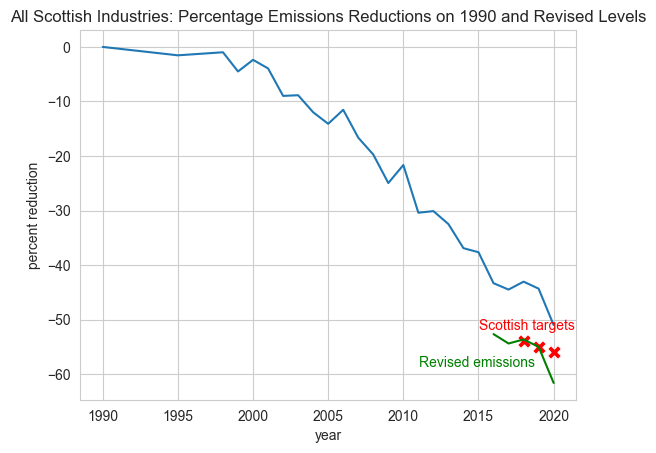

In [32]:
fig, ax = plt.subplots()

#plotting the original summed emissions data
ax1 = sns.lineplot(data=all_emissions, x='emission_year', y='pct_of_baselevel')
#plotting the Scottish government targets
ax2 = sns.scatterplot(data=targets_df[targets_df['emission_year'] < 2021], x='emission_year', y='pct_of_baselevel',
               marker='X', color='red', s=100)
#plotting the new revised emissions data
ax3 = sns.lineplot(data=revised_emissions, x='emission_year', y='pct_of_baselevel', color='green')


ax.text(.9, .2, 'Scottish targets', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='red')

ax.text(.8, .1, 'Revised emissions', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='green')


plt.title('All Scottish Industries: Percentage Emissions Reductions on 1990 and Revised Levels')
plt.xlabel('year')
plt.ylabel('percent reduction')
plt.show()

As we can see above, the revised accounting places Scottish industries beneath the Scottish Government targets since 2018. 

The revised accounting was put in place to allow Scottish reporting to:
- Meet the requirements from the UN Framework Convention on Climate Change, in particular taking into account changes in scientific measurement over time. For example, the measuring of additional greenhouse gases in later years than were accounted for in the 1990 baseline.
- Take into account the nature of Scottish industry. For example, Scotland has a greater proportion of harder to measure industries, such as Agriculture and Land Use/Forestry than other British nations.